<a href="https://colab.research.google.com/github/poojashreeNS/ANN_Techniques/blob/main/Conversational_Sentiment_Analysis_6_Zeyneb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [ ]:
!pip install tensorflow
!pip install livelossplot   
!pip install shap 
!pip install transformers     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 9.7 MB/s 
     |████████████████████████████████| 381 kB 9.3 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 596 kB 69.9 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

import random
import re 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

import tensorflow as tf 
import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Conv1D, Flatten, MaxPooling1D, Dropout, GlobalMaxPooling1D, Bidirectional, GRU, CuDNNGRU, Activation, GlobalAveragePooling1D 
from keras.layers import Dot, Reshape, TimeDistributed, concatenate, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.models import Model

from keras.losses import SparseCategoricalCrossentropy
from livelossplot import PlotLossesKeras
from keras.callbacks import Callback

from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 
from transformers import TFBertModel, BertConfig, BertTokenizer,TFBertForSequenceClassification

from keras.utils.vis_utils import plot_model 

from google.colab import files


### Load Data + basic functions

In [ ]:
tabular_cols = [ 
                'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'WC',  
                'BigWords', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 
                'i', 'we', 'you', 'shehe', 'they', 'ipron', 'det', 'article', 'number', 
                'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'quantity', 
                'Drives', 'affiliation', 'achieve', 'power', 'Cognition', 'allnone', 
                'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude', 
                'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emo_pos', 
                'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'swear', 'Social', 
                'socbehav', 'prosocial', 'polite', 'conflict', 'moral', 'comm', 'socrefs', 
                'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech',
                'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 
                'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 
                'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 
                'reward', 'risk', 'curiosity', 'allure', 'Perception', 'attention', 'motion',
                'space', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'focuspresent',
                'focusfuture', 'Conversation', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc',
                'Apostro', 'OtherP', 'voice_probability', 'pcm_loudness', 'F0']

In [ ]:
 
## prepare data 
 
def load_prep_data(data,texts,prosodics,is_train=True):
  
  # match ids to get target  
  if is_train:
    data['target'] = data['instance_num'].apply(lambda x: prosodics[prosodics['instance_num']==x]['emotion'].values[0])
  else:
    data['target'] = data['instance_num'].apply(lambda x: prosodics[prosodics['instance_num']==x]['emotion_1'].values[0])

  # encode target
  
  encoder = {'Contempt' : 0, 'Sadness' : 1, 'Frustration' : 2, 'Boredom' : 3, 'Surprise' : 4, 'Interest' : 5, 'Joy' : 6}
  le = data['target'].apply(lambda x: encoder[x]).values 
  
  out_classes = to_categorical( 
    le, num_classes=7) 
 
  data['target'] = out_classes 
  
  # match ids to get other features 
  temp_vp = []
  temp_pcm = []
  temp_f0 = []
  for x in data['instance_num'].values:
    temp = prosodics[prosodics['instance_num']==x] 
    temp_vp.append(temp['voice_probability'].values[0])
    temp_pcm.append(temp['pcm_loudness'].values[0])
    temp_f0.append(temp['F0'].values[0])
  
  data['voice_probability'] = temp_vp
  data['pcm_loudness'] = temp_pcm
  data['F0'] = temp_f0
  
  #drops = data.describe().transpose()[data.describe().transpose()['std'] == 0 ].index.to_list( )
  
  liwc_aud = data[tabular_cols]
  liwc = liwc_aud.drop(['voice_probability', 'pcm_loudness', 'F0'],axis=1).to_numpy()
  aud = liwc_aud[['voice_probability', 'pcm_loudness', 'F0']].to_numpy()
  
  text = texts['transcript'].values
  text_y = texts['emotion_1'].values
  
  le_t = np.array([encoder[c] for c in text_y])
  text_y = to_categorical( 
    le_t, num_classes=7) 
  
  return liwc_aud.to_numpy(), liwc, aud, text, out_classes, text_y 


In [ ]:
## text preprocessing

from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_list = stopwords.words('english')  
stop_list.extend(['yeah','um'])

def preprocess(text):
    ## simple cleaning 
    if type(text)!=str:
      return ''
    text = text.lower()
    text = re.sub(r'[/(){}\[\]\|@,;]',' ',text)
    text = ' '.join([w for w in text.split(' ') if w not in stop_list])
    #stemmer = PorterStemmer()
    #text = ' '.join([stemmer.stem(w) for w in text.split(' ')])

    return text  

def preprocess_version_2(text):
    ## simple cleaning 
    if type(text)!=str:
      return ''
    text = text.lower()
    #text = re.sub(r'[/(){}\[\]\|@,;]',' ',text)
    #text = ' '.join([w for w in text.split(' ') if w not in stop_list])
    #stemmer = PorterStemmer()
    #text = ' '.join([stemmer.stem(w) for w in text.split(' ')])

    return text         

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/training_balanced/balanced_training_liwc_features.csv')
train_texts = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/training_balanced/balanced_training_utterance.csv')
train_auds = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/training_balanced/balanced_training_prosodic_features.csv')

X_train_tab,X_train_liwc,X_train_aud, X_train_text, y_train_tab, y_train_text = load_prep_data(train_data, train_texts, train_auds)

test_data = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/test/test_liwc.csv')
test_texts = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/test/test_utterance.csv')
test_auds = pd.read_csv('/content/drive/MyDrive/ICANN/Proj-Conversational-ASIST/MISC-ASIST/test/test_prosodic.csv')
  
X_test_tab, X_test_liwc, X_test_aud, X_test_text, y_test_tab, y_test_text = load_prep_data(test_data, test_texts, test_auds, False)


In [ ]:
X_train_text = np.array([preprocess_version_2(text) for text in X_train_text])  
X_test_text = np.array([preprocess_version_2(text) for text in X_test_text])

In [ ]:
X_train_tab.shape, X_train_text.shape, y_train_tab.shape, y_train_text.shape

((28245, 115), (28245,), (28245, 7), (28245, 7))

In [ ]:
X_test_tab.shape, X_test_text.shape, y_test_tab.shape, y_test_text.shape 

((1547, 115), (1547,), (1547, 7), (1547, 7))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


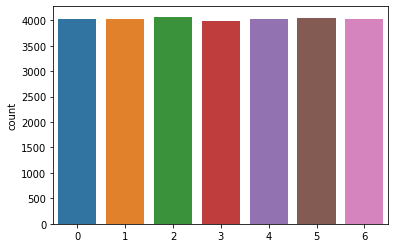

In [ ]:
sns.countplot([c.argmax() for c in y_train_tab])  

In [ ]:
def predictions(preds):
  z = np.zeros(len(preds))
  z[np.argmax(preds)] = 1 
  return z
  
  return z  
def evaluate_model(y_true, y_preds):
  print(classification_report([np.argmax(y) for y in y_true],[np.argmax(y) for y in y_preds]))
  print(confusion_matrix([np.argmax(y) for y in y_true],[np.argmax(y) for y in y_preds]))
 

# Check

In [ ]:
X_train_tab.shape, X_train_text.shape, y_train_tab.shape, y_train_text.shape 

((28245, 115), (28245,), (28245, 7), (28245, 7))

In [ ]:
X_train_tab[0], X_train_text[0], y_train_tab[0]

(array([89.52      , 40.06      ,  1.        , 20.23      , 11.        ,
        11.        , 18.18      , 81.82      , 63.64      , 54.55      ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 27.27      , 18.18      ,
         0.        ,  9.09      , 18.18      ,  9.09      ,  0.        ,
         0.        , 27.27      ,  0.        ,  9.09      ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  9.09      ,  9.09      ,  0.        ,
         0.        ,  0.        ,  0.        ,  9.09      ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

# Models (Text)

BERT [fine tune by itsself]

In [ ]:
def tokenize_bert(X_train_text,y_train_text, tokenizer):
  

  input_ids=[]
  attention_masks=[]

  for sent in X_train_text:
      bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =100,pad_to_max_length = True,return_attention_mask = True)
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask']) 
  
  input_ids=np.asarray(input_ids)
  attention_masks=np.array(attention_masks)
  labels=np.array([np.argmax(c) for c in y_train_text]) 

  return input_ids, attention_masks, labels 


In [ ]:
def train_bert(X_train_text, X_test_text, y_train_text, y_test_text, name, model, tokenizer):
  X_train_input_ids, X_train_attention_masks, y_train_labels = tokenize_bert(X_train_text,y_train_text,tokenizer)
  X_test_input_ids, X_test_attention_masks, y_test_labels = tokenize_bert(X_test_text,y_test_text,tokenizer)  
  
  model_bert = model
  model_bert.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5,epsilon=1e-08,clipnorm=1.0),
      loss=SparseCategoricalCrossentropy(from_logits=True),
      metrics=["accuracy"],
  )  

  model_bert.fit( 
      [X_train_input_ids,X_train_attention_masks], y_train_labels, 
      epochs=4, 
      batch_size=64,  
      callbacks = [PlotLossesKeras()],
      validation_split=0.2
  )
  model.save_weights(name ) 
  # files.download('/content/'+name) 

  
  ## loading weights for predicting
  model_bert = model
  model_bert.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5,epsilon=1e-08,clipnorm=1.0),
      loss=SparseCategoricalCrossentropy(from_logits=True),
      metrics=["accuracy"]
  )  

  model_bert.load_weights('/content/'+name)
  pred_bert = model_bert.predict([X_test_input_ids, X_test_attention_masks])
  print(evaluate_model(y_test_text, np.array(tf.nn.softmax(pred_bert[0])))) 

  return model_bert 
  

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer 

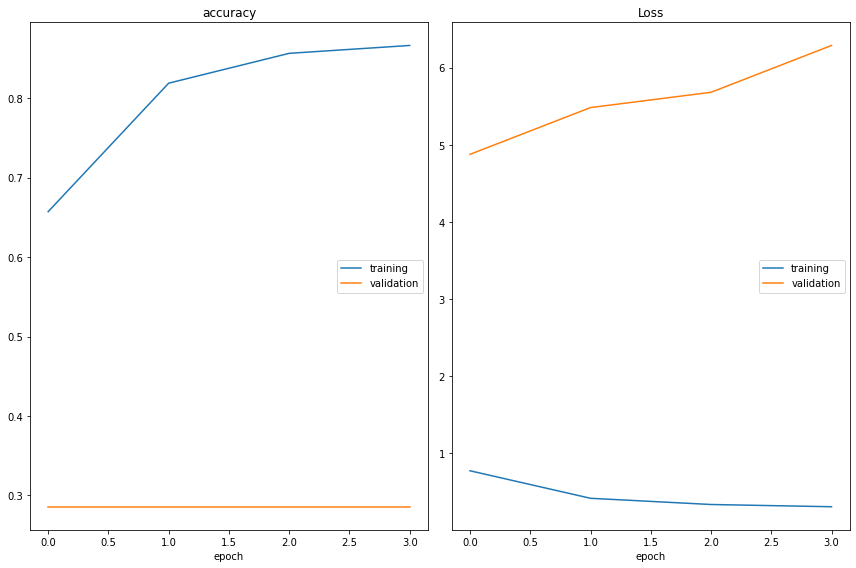

accuracy
	training         	 (min:    0.657, max:    0.866, cur:    0.866)
	validation       	 (min:    0.286, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    0.309, max:    0.776, cur:    0.309)
	validation       	 (min:    4.876, max:    6.287, cur:    6.287)
354/354 [==============================] - 280s 790ms/step - loss: 0.3095 - accuracy: 0.8664 - val_loss: 6.2868 - val_accuracy: 0.2857
              precision    recall  f1-score   support

           0       0.01      0.08      0.02        25
           1       0.00      0.00      0.00       119
           2       0.35      0.21      0.26       383
           3       1.00      0.02      0.03       243
           4       0.02      0.05      0.03        19
           5       0.51      0.68      0.58       758
           6       0.00      0.00      0.00         0

    accuracy                           0.39      1547
   macro avg       0.27      0.15      0.13      1547
weighted avg       0.49      0.39      0.36  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
 
model_bert = train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'roberta_base_ft_ver2',TFRobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=7),
            RobertaTokenizer.from_pretrained('roberta-base') 
) 


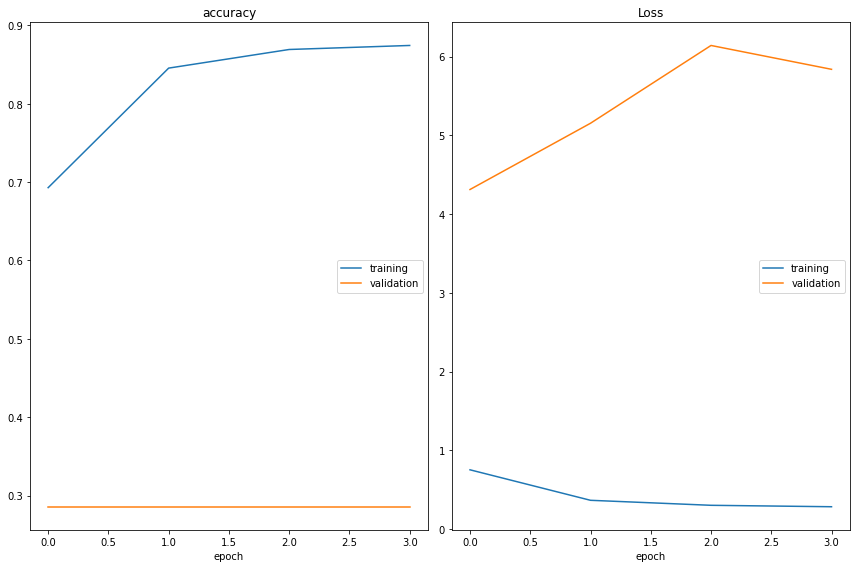

accuracy
	training         	 (min:    0.693, max:    0.874, cur:    0.874)
	validation       	 (min:    0.286, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    0.285, max:    0.754, cur:    0.285)
	validation       	 (min:    4.312, max:    6.140, cur:    5.838)
354/354 [==============================] - 278s 786ms/step - loss: 0.2854 - accuracy: 0.8744 - val_loss: 5.8375 - val_accuracy: 0.2857
              precision    recall  f1-score   support

           0       0.02      0.08      0.03        25
           1       0.00      0.00      0.00       119
           2       0.34      0.21      0.26       383
           3       1.00      0.02      0.03       243
           4       0.01      0.05      0.01        19
           5       0.50      0.61      0.55       758
           6       0.00      0.00      0.00         0

    accuracy                           0.36      1547
   macro avg       0.27      0.14      0.13      1547
weighted avg       0.49      0.36      0.34  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
model_bert = train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'bert_base_ft_ver5',TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7),
            BertTokenizer.from_pretrained('bert-base-uncased') 
) 


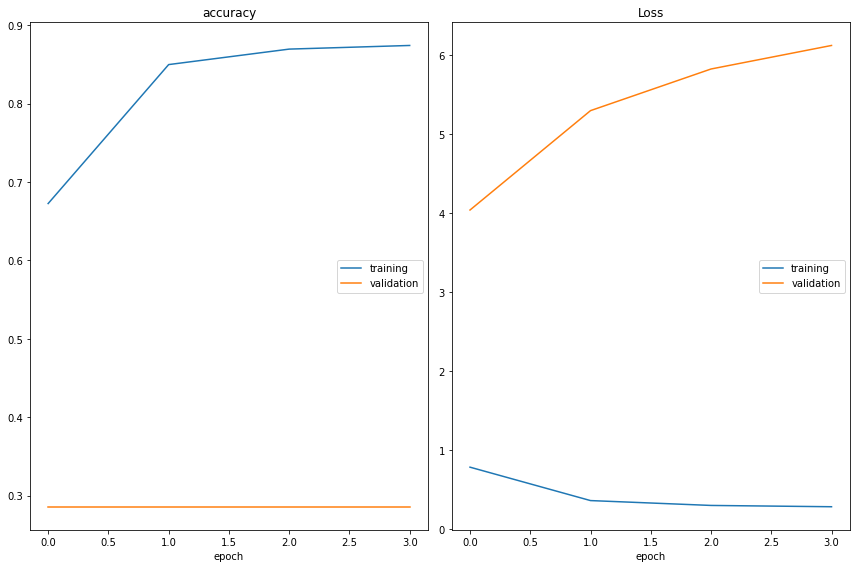

accuracy
	training         	 (min:    0.672, max:    0.874, cur:    0.874)
	validation       	 (min:    0.286, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    0.287, max:    0.787, cur:    0.287)
	validation       	 (min:    4.042, max:    6.124, cur:    6.124)
354/354 [==============================] - 278s 785ms/step - loss: 0.2865 - accuracy: 0.8740 - val_loss: 6.1244 - val_accuracy: 0.2857
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        25
           1       0.00      0.00      0.00       119
           2       0.36      0.18      0.24       383
           3       1.00      0.02      0.03       243
           4       0.01      0.21      0.02        19
           5       0.50      0.67      0.57       758
           6       0.00      0.00      0.00         0

    accuracy                           0.38      1547
   macro avg       0.34      0.16      0.13      1547
weighted avg       0.50      0.38      0.35  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
model_bert = train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'bert_base_ft_ver4',TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7),
            BertTokenizer.from_pretrained('bert-base-uncased') 
) 
 

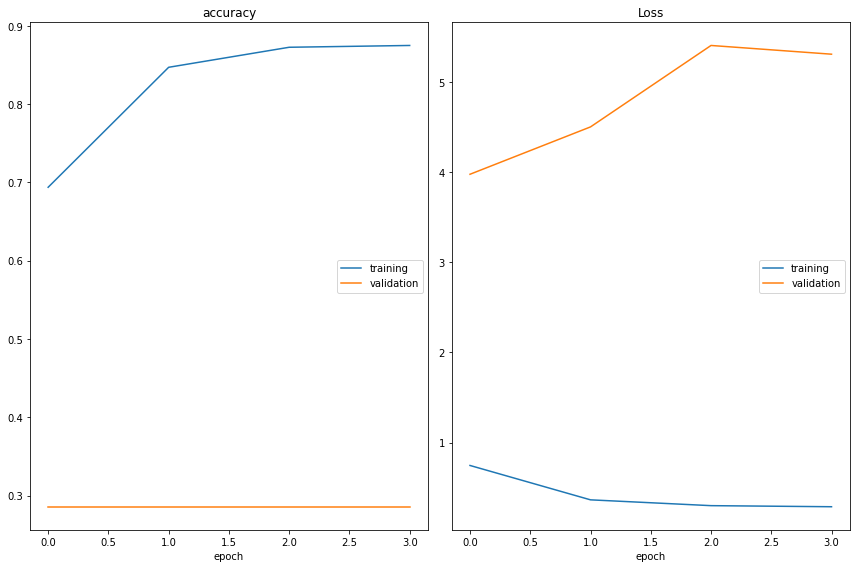

accuracy
	training         	 (min:    0.694, max:    0.875, cur:    0.875)
	validation       	 (min:    0.286, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    0.289, max:    0.747, cur:    0.289)
	validation       	 (min:    3.974, max:    5.402, cur:    5.305)
354/354 [==============================] - 278s 786ms/step - loss: 0.2895 - accuracy: 0.8749 - val_loss: 5.3051 - val_accuracy: 0.2857
              precision    recall  f1-score   support

           0       0.02      0.08      0.03        25
           1       0.00      0.00      0.00       119
           2       0.37      0.28      0.32       383
           3       1.00      0.02      0.03       243
           4       0.01      0.16      0.03        19
           5       0.51      0.61      0.56       758
           6       0.00      0.00      0.00         0

    accuracy                           0.37      1547
   macro avg       0.27      0.16      0.14      1547
weighted avg       0.50      0.37      0.36  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

'\n              precision    recall  f1-score   support\n\n           0       0.02      0.08      0.03        25\n           1       0.00      0.00      0.00       119\n           2       0.31      0.18      0.23       383\n           3       1.00      0.02      0.03       243\n           4       0.02      0.16      0.04        19\n           5       0.51      0.68      0.58       758\n           6       0.00      0.00      0.00         0\n\n    accuracy                           0.38      1547\n   macro avg       0.27      0.16      0.13      1547\nweighted avg       0.48      0.38      0.35      1547\n\n[[  2   0   3   0   4  16   0]\n [ 16   0   5   0  18  80   0]\n [ 38   0  69   0  20 246  10]\n [  8   0  56   4  29 137   9]\n [  1   0   4   0   3  11   0]\n [ 61   0  87   0  74 514  22]\n [  0   0   0   0   0   0   0]]\n\n'

In [ ]:
model_bert = train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'bert_base_ft_ver3',TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7),
            BertTokenizer.from_pretrained('bert-base-uncased') 
) 

## output
'''
              precision    recall  f1-score   support

           0       0.02      0.08      0.03        25
           1       0.00      0.00      0.00       119
           2       0.31      0.18      0.23       383
           3       1.00      0.02      0.03       243
           4       0.02      0.16      0.04        19
           5       0.51      0.68      0.58       758
           6       0.00      0.00      0.00         0

    accuracy                           0.38      1547
   macro avg       0.27      0.16      0.13      1547
weighted avg       0.48      0.38      0.35      1547

[[  2   0   3   0   4  16   0]
 [ 16   0   5   0  18  80   0]
 [ 38   0  69   0  20 246  10]
 [  8   0  56   4  29 137   9]
 [  1   0   4   0   3  11   0]
 [ 61   0  87   0  74 514  22]
 [  0   0   0   0   0   0   0]]

'''

In [ ]:
## base bert without further training for comparison
model_bert_BASE = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7)
X_test_input_ids, X_test_attention_masks, y_test_labels = tokenize_bert(X_test_text,y_test_text, BertTokenizer.from_pretrained('bert-base-uncased')) 
pred_bert_BASE = model_bert_BASE.predict([X_test_input_ids,X_test_attention_masks])
evaluate_model(y_test_text, np.array(tf.nn.softmax(pred_bert_BASE[0])))  

## output
'''
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.11      0.13      0.12       119
           2       0.36      0.01      0.02       383
           3       0.00      0.00      0.00       243
           4       0.02      0.42      0.03        19
           5       0.48      0.01      0.03       758
           6       0.00      0.00      0.00         0

    accuracy                           0.03      1547
   macro avg       0.14      0.08      0.03      1547
weighted avg       0.33      0.03      0.03      1547

[[  0   4   0   0   3   0  18]
 [  0  16   1   0  32   0  70]
 [  0  37   4   0 125   8 209]
 [  0  20   0   0  77   3 143]
 [  0   3   0   0   8   1   7]
 [  0  66   6   0 206  11 469]
 [  0   0   0   0   0   0   0]] 
'''

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the b

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00       119
           2       0.25      0.97      0.39       383
           3       0.00      0.00      0.00       243
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00       758
           6       0.00      0.00      0.00         0

    accuracy                           0.24      1547
   macro avg       0.04      0.14      0.06      1547
weighted avg       0.06      0.24      0.10      1547

[[  0   0  24   0   0   0   1]
 [  0   0 118   0   0   0   1]
 [  0   0 370   1   0   0  12]
 [  0   0 231   0   0   0  12]
 [  0   0  19   0   0   0   0]
 [  0   0 732   0   0   0  26]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

'\n              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        25\n           1       0.11      0.13      0.12       119\n           2       0.36      0.01      0.02       383\n           3       0.00      0.00      0.00       243\n           4       0.02      0.42      0.03        19\n           5       0.48      0.01      0.03       758\n           6       0.00      0.00      0.00         0\n\n    accuracy                           0.03      1547\n   macro avg       0.14      0.08      0.03      1547\nweighted avg       0.33      0.03      0.03      1547\n\n[[  0   4   0   0   3   0  18]\n [  0  16   1   0  32   0  70]\n [  0  37   4   0 125   8 209]\n [  0  20   0   0  77   3 143]\n [  0   3   0   0   8   1   7]\n [  0  66   6   0 206  11 469]\n [  0   0   0   0   0   0   0]] \n'

### [BERT, DistilBERT, RoBERTa...] Embedding + [BiLSTM, BiGRU...]

In [ ]:
# tokenizes + attention mask 

max_seq = 112

def tokenize(sentences, tokenizer):

    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, 
                                        max_length=max_seq, 
                                        pad_to_max_length=True, 
                                        return_attention_mask=True, 
                                        return_token_type_ids=True, 
                                        truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
          
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32') 



In [ ]:
from keras.layers import Input, Bidirectional, LSTM, GlobalMaxPool1D,Dense,Dropout
from keras import Model

In [ ]:
## Model - BERT + Bidirectional LSTM w/ Attention
def train_bert_bilstm(X_train, y_train, X_test, y_test, model,path_for_ft,tokenizer, ver,outdim=7):
  
  X_train_encoding = tokenize(X_train, tokenizer)
  X_test_encoding = tokenize(X_test, tokenizer)

  BERT = model 
  BERT.load_weights(path_for_ft)
  
  ## set up model architecture

  input_ids_in = Input(shape=(max_seq,), name='input_token', dtype='int32')
  input_masks_in = Input(shape=(max_seq,), name='masked_token', dtype='int32') 


  embedding_layer = BERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
  X = Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
  X = GlobalMaxPool1D()(X) 
  X = Dense(64, activation='relu')(X)
  X = Dropout(0.2)(X)
  X = Dense(outdim, activation='softmax')(X)

  model = Model(inputs=[input_ids_in, input_masks_in], outputs = X)

  for layer in model.layers[:3]:
      layer.trainable = False

  model.summary()   
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

  #checkpt = ModelCheckpoint(ver + '.h5', monitor="val_recall", mode='min', save_best_only=True)
  
  history = model.fit(X_train_encoding,  
                      y_train,
                      epochs = 8,
                      batch_size=32,
                      validation_split=0.1,callbacks=[PlotLossesKeras()]) #,checkpt])
  
  pred_bert = model.predict(X_test_encoding) 
  #pred_bert = [predictions(p) for p in pred_bert]
  evaluate_model(y_test, pred_bert)
  
  model.save(ver) 


In [ ]:
train_bert_bilstm(X_train_text, y_train_text, X_test_text, y_test_text,
                  TFBertModel.from_pretrained('bert-base-uncased',num_labels=7),
                  '/content/bert_base_ft_ver3',BertTokenizer.from_pretrained('bert-base-cased'),'bert_bilstm_ver_3')

'''
output (classes shifted)
              precision    recall  f1-score   support

           1       0.01      0.08      0.02        25
           2       0.50      0.02      0.03       119
           3       0.24      0.25      0.25       383
           4       0.26      0.02      0.05       243
           5       0.02      0.32      0.03        19
           6       0.56      0.15      0.24       758
           7       0.00      0.00      0.00         0

    accuracy                           0.15      1547
   macro avg       0.23      0.12      0.09      1547
weighted avg       0.41      0.15      0.19      1547

[[  2   0   4   0   3   4  12]
 [ 30   2  23   0  41  10  13]
 [ 63   1  96  11  78  56  78]
 [ 17   0  90   6  49  23  58]
 [  3   0   6   0   6   0   4]
 [112   1 176   6 162 117 184]
 [  0   0   0   0   0   0   0]]
'''


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 112)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 112)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 112,                                           

KeyboardInterrupt: ignored

In [ ]:
## Model - BERT + Bidirectional LSTM w/ Attention
def train_bert_bilstm2(X_train, y_train, X_test, y_test, ver,outdim=7):
  
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

  X_train_encoding = tokenize(X_train, tokenizer)
  X_test_encoding = tokenize(X_test, tokenizer)


  config = BertConfig.from_pretrained('bert-base-cased', output_hidden_states=True, output_attentions=True) ## transfer learning
  BERT = TFBertModel.from_pretrained('bert-base-cased', config=config)
  
  
  ## set up model architecture

  input_ids_in = keras.layers.Input(shape=(max_seq,), name='input_token', dtype='int32')
  input_masks_in = keras.layers.Input(shape=(max_seq,), name='masked_token', dtype='int32') 


  embedding_layer = BERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
  X = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
  X = keras.layers.GlobalMaxPool1D()(X) 
  X = keras.layers.Dense(64, activation='relu')(X)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.Dense(outdim, activation='softmax')(X)

  model = keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

  for layer in model.layers[:3]:
      layer.trainable = True

  model.summary()   
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

  #checkpt = ModelCheckpoint(ver + '.h5', monitor="val_recall", mode='min', save_best_only=True)
  
  history = model.fit(X_train_encoding,  
                      y_train,
                      epochs = 5,
                      batch_size=32,
                      validation_split=0.1,callbacks=[PlotLossesKeras()]) #,checkpt])
  
  pred_bert = model.predict(X_test_encoding) 
  #pred_bert = [predictions(p) for p in pred_bert]
  evaluate_model(y_test, pred_bert)
  
  model.save(ver)   

train_bert_bilstm2(X_train_text, y_train_text, X_test_text, y_test_text,'bert_bilstm_ver_4')


In [ ]:
## distilbert  
from transformers import TFDistilBertModel, TFDistilBertForSequenceClassification

train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'distilbert_base_ft_ver1.h5',TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased',num_labels=7),
           DistilBertTokenizer.from_pretrained('distilbert-base-cased'))  

train_bert_bilstm(X_train_text, y_train_text, X_test_text, y_test_text,
                  TFDistilBertModel.from_pretrained('distilbert-base-cased',num_labels=7),
                  '/content/distilbert_base_ft_ver1.h5',DistilBertTokenizer.from_pretrained('distilbert-base-cased'),
                  'distilbert_bilstm_ver_1')

   

In [ ]:
## roberta 
from transformers import TFRobertaModel, RobertaTokenizer, TFRobertaForSequenceClassification 

train_bert(X_train_text, X_test_text, y_train_text, y_test_text, 
           'roberta_base_ft_ver1.h5',TFRobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=7),
           RobertaTokenizer.from_pretrained('roberta-base'))  

train_bert_bilstm(X_train_text, y_train_text, X_test_text, y_test_text,
                  TFRobertaModel.from_pretrained('roberta-base',num_labels=7),
                  '/content/roberta_base_ft_ver1.h5',RobertaTokenizer.from_pretrained('roberta-base'),
                  'roberta_bilstm_ver_1')



In [ ]:
def train_bert_bigru(X_train, y_train, X_test, y_test, model,path_for_ft,tokenizer, ver,outdim=7): 
 
  X_train_encoding = tokenize(X_train, tokenizer)
  X_test_encoding = tokenize(X_test, tokenizer) 

  BERT = model 
  BERT.load_weights(path_for_ft)

  
  input_ids_in = keras.layers.Input(shape=(max_seq,), name='input_token', dtype='int32')
  input_masks_in = keras.layers.Input(shape=(max_seq,), name='masked_token', dtype='int32')

  embedding = BERT(input_ids = input_ids_in, attention_mask=input_masks_in)[0] 
  gru = Bidirectional(GRU(128))(embedding)
  drop = Dropout(0.5)(gru)    

  out = Dense(128, activation='relu')(drop) 
  out_2 = Dense(64, activation='relu')(drop)  
  outputs = Dense(7, activation='softmax')(out_2) 

  model = Model(inputs=[input_ids_in,input_masks_in], outputs=outputs)   
  
  for layer in model.layers[:3]:
        layer.trainable = False 

  model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  model.fit(X_train_encoding, y_train_text, epochs=10,batch_size=64)  

  pred_bert = model.predict(X_test_encoding) 
  evaluate_model(y_test, pred_bert)
  

 

In [ ]:
train_bert_bigru(X_train_text, y_train_text, X_test_text, y_test_text,
                  TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=7),
                  '/content/bert_base_ft_ver5.index',BertTokenizer.from_pretrained('bert-base-cased'),'bert_bigru_ver_2')




### More Experiments

In [ ]:
from gensim.models import Word2Vec 


In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train_text) 
X_train_texts_tokenized = tokenizer.texts_to_sequences(X_train_text)
X_test_texts_tokenized = tokenizer.texts_to_sequences(X_test_text)

X_train_texts_tokenized = pad_sequences(X_train_texts_tokenized, maxlen=max_seq)
X_test_texts_tokenized = pad_sequences(X_test_texts_tokenized, maxlen=max_seq)

embedding_dict={}
with open('/content/glove.6B.100d.txt','r') as f: 
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

word_index=tokenizer.word_index


num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in word_index.items():
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec 


num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in word_index.items():
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
     

In [ ]:
def ensemble_CNN_BiGRU(filters = 100, kernel_size = 3, activation='relu', 
                   input_dim = None, output_dim=300, max_length = None, emb_matrix = None):
    
    # Channel 1D CNN
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(input_dim=input_dim, 
                            output_dim=output_dim, 
                            input_length=max_length, 
                            input_shape=(max_length, ),
                            # Assign the embedding weight with word2vec embedding marix
                            weights = [emb_matrix],
                            # Set the weight to be not trainable (static)
                            trainable = False)(input1)
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                   kernel_constraint= keras.constraints.MaxNorm( max_value=3, axis=[0,1]))(embeddding1)
    pool1 = keras.layers.MaxPool1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(10, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(1, activation='sigmoid')(drop1)
    
    # Channel BiGRU
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(input_dim=input_dim, 
                            output_dim=output_dim, 
                            input_length=max_length, 
                            input_shape=(max_length, ),
                            # Assign the embedding weight with word2vec embedding marix
                            weights = [emb_matrix],
                            # Set the weight to be not trainable (static)
                            trainable = False,
                            mask_zero=True)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(1, activation='sigmoid')(drop2)
    
    # Merge
    merged = concatenate([out1, out2])
    
    # Interpretation
    outputs = Dense(7, activation='softmax')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)
    
    # Compile
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = ensemble_CNN_BiGRU(filters = 100, kernel_size = 3, activation='relu', 
                   input_dim = 2502, output_dim=100, max_length = 112, emb_matrix = embedding_matrix)
model.fit([X_train_texts_tokenized,X_train_texts_tokenized], y_train_text)


# Tabular

In [ ]:
def train_model1_liwcaud(X_train,y_train,X_test,y_test,name,num_out=7,loss='categorical_crossentropy',cw=None, epochs = 350):
  model = Sequential()  
  model.add(Dense(256,activation='relu',input_shape=(X_train.shape[-1],)))
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_out,activation='softmax'))
  model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy',Recall()])
  print(model.summary()) 

  # normalize tabulars 
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test) 
 
  early_stop = EarlyStopping(monitor=Recall(), mode='min', patience=10) 
  checkpt = ModelCheckpoint(name + '.h5', monitor=Recall(), mode='min', save_best_only=True)  
   
                                             
  pred_dbert = model.predict(X_test)
  pred_dbert = [predictions(p) for p in pred_dbert]
  print(evaluate_model(y_test, pred_dbert)) 
  model.save(name)    

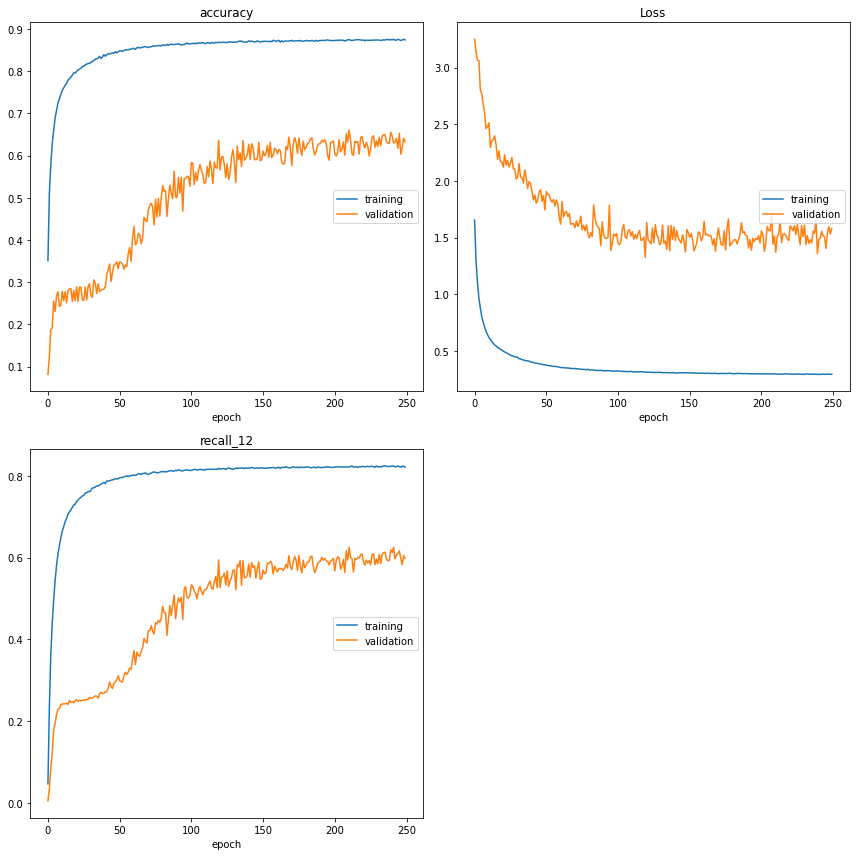

accuracy
	training         	 (min:    0.351, max:    0.876, cur:    0.874)
	validation       	 (min:    0.081, max:    0.660, cur:    0.633)
Loss
	training         	 (min:    0.293, max:    1.655, cur:    0.294)
	validation       	 (min:    1.323, max:    3.251, cur:    1.580)
recall_12
	training         	 (min:    0.047, max:    0.824, cur:    0.821)
	validation       	 (min:    0.004, max:    0.625, cur:    0.598)
707/707 [==============================] - 3s 4ms/step - loss: 0.2943 - accuracy: 0.8740 - recall_12: 0.8214 - val_loss: 1.5799 - val_accuracy: 0.6327 - val_recall_12: 0.5982
              precision    recall  f1-score   support

           0       0.14      1.00      0.25        25
           1       0.60      0.80      0.68       119
           2       0.95      0.79      0.86       383
           3       0.96      0.79      0.87       243
           4       1.00      0.79      0.88        19
           5       0.93      0.78      0.85       758
           6       0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model_liwc_only_1/assets


In [ ]:
train_model1_liwcaud(X_train_liwc,y_train_tab,X_test_liwc,y_test_tab,'model_liwc_only_1',epochs=250)   

Prosodic Model

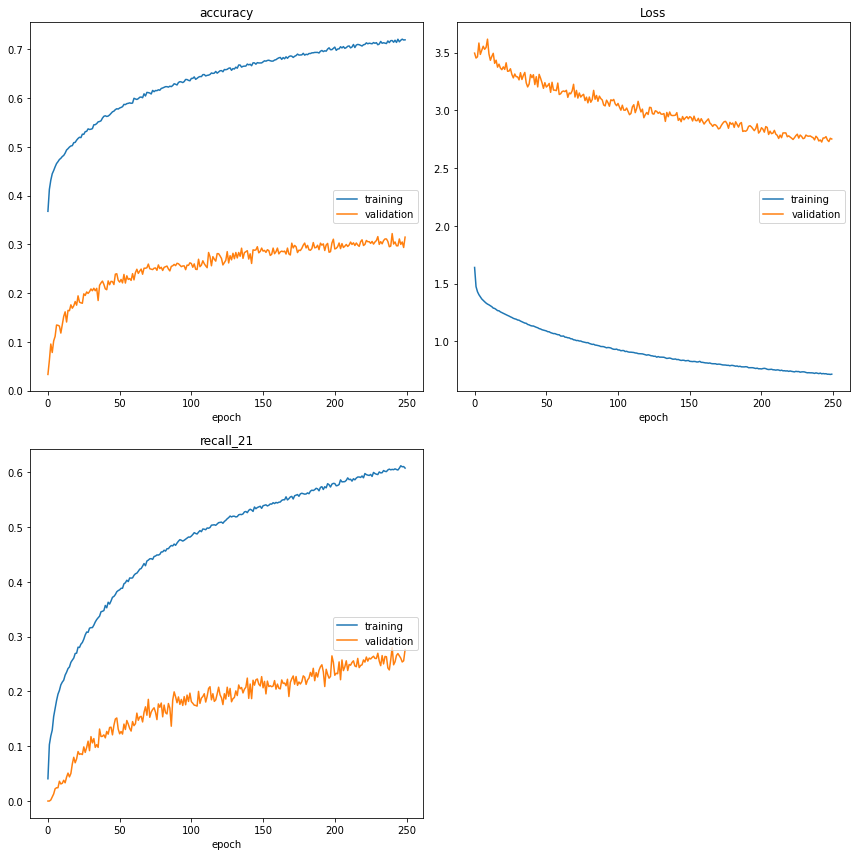

accuracy
	training         	 (min:    0.368, max:    0.721, cur:    0.719)
	validation       	 (min:    0.033, max:    0.322, cur:    0.315)
Loss
	training         	 (min:    0.713, max:    1.639, cur:    0.715)
	validation       	 (min:    2.726, max:    3.616, cur:    2.752)
recall_21
	training         	 (min:    0.041, max:    0.612, cur:    0.607)
	validation       	 (min:    0.000, max:    0.281, cur:    0.276)
707/707 [==============================] - 3s 4ms/step - loss: 0.7154 - accuracy: 0.7192 - recall_21: 0.6074 - val_loss: 2.7519 - val_accuracy: 0.3147 - val_recall_21: 0.2762
              precision    recall  f1-score   support

           0       0.40      0.96      0.56        25
           1       0.37      0.92      0.53       119
           2       0.49      0.49      0.49       383
           3       0.45      0.86      0.59       243
           4       0.00      0.00      0.00        19
           5       0.68      0.27      0.38       758
           6       0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model_aud_only_1/assets


In [ ]:
train_model1_liwcaud(X_train_aud,y_train_tab,X_test_aud,y_test_tab,'model_aud_only_1',epochs=250)   
   

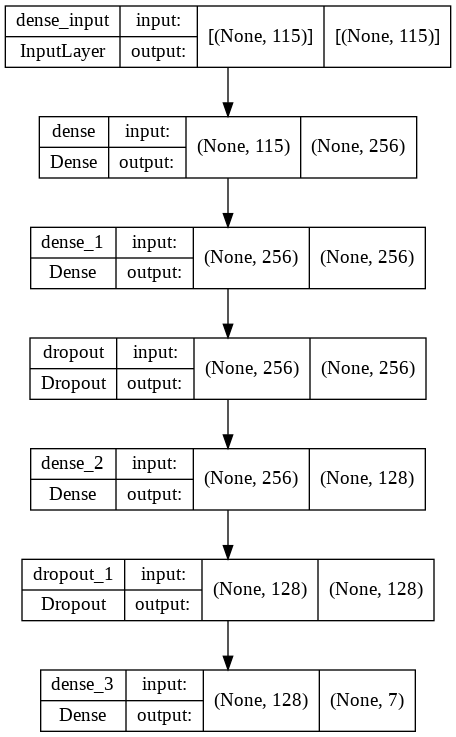

In [ ]:
model = keras.models.load_model('/content/new/content/model_liwc_3')
from keras.utils.vis_utils import plot_model 
plot_model(model, show_shapes=True, show_layer_names=True)  

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_tab)
X_test_s = scaler.transform(X_test_tab)  

In [ ]:
!pip install shap

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


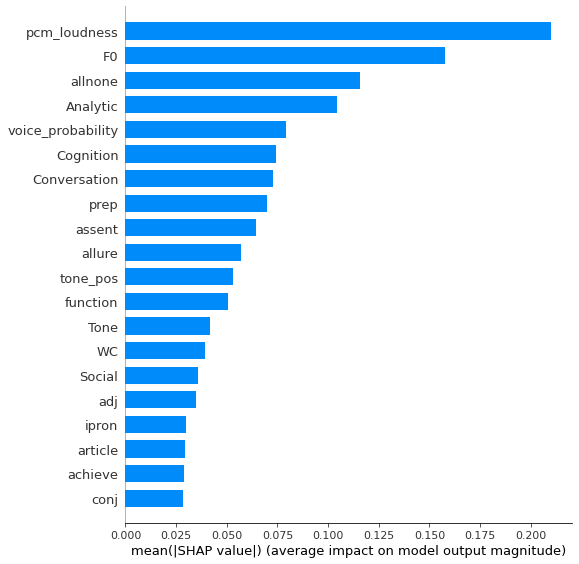

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
import shap

liwc_model = keras.models.load_model('/content/model_liwc_3')
# SHAP values
shap_exp = shap.DeepExplainer(liwc_model, X_train_s)
shap_values = shap_exp.shap_values(X_test_s[:10]) 
 
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = tabular_cols)
## POSEMO = positive emotion  

MultiChannel LIWC + Prosodic

In [ ]:
def train_multichannel_liwcaud(X_train_liwc,X_train_aud,y_train,X_test_liwc,X_test_aud,y_test,name,num_out=7,loss='categorical_crossentropy',cw=None, epochs=350):
  
  
  ## liwc 
  inputs_text = Input(shape=(X_train_liwc.shape[-1],))
  X_text = Dense(256,activation='relu')(inputs_text)
  X_text = Dense(256,activation='relu')(X_text)
  X_text = Dropout(0.3)(X_text)
  X_text = Dense(128,activation='relu')(X_text)
  X_text = Dropout(0.3)(X_text)
  X_text = Dense(128,activation='relu')(X_text)
  flat_text = Flatten()(X_text)

  ## prosodic  
  inputs_aud = Input(shape=(X_train_aud.shape[-1],))
  X_aud = Dense(256,activation='relu')(inputs_aud)
  X_aud = Dense(256,activation='relu')(X_aud)
  X_aud = Dropout(0.3)(X_aud)
  X_aud = Dense(128,activation='relu')(X_aud)
  X_aud = Dropout(0.3)(X_aud)
  X_aud = Dense(128,activation='relu')(X_aud)
  flat_aud = Flatten()(X_aud) 
   
  # normalize tabulars 
  scaler = StandardScaler()
  X_train_liwc = scaler.fit_transform(X_train_liwc)
  X_test_liwc = scaler.transform(X_test_liwc) 

  X_train_aud = scaler.fit_transform(X_train_aud)
  X_test_aud = scaler.transform(X_test_aud) 
    
  merged = concatenate([flat_text, flat_aud])

  dense1 = Dense(128, activation='relu')(merged)
  dense2 = Dense(64, activation='relu')(dense1)
  outputs = Dense(7, activation='softmax')(dense2)

  
  model = Model(inputs=[inputs_text, inputs_aud], outputs=outputs)
  for layer in model.layers[:3]:
    layer.trainable = False  
     
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

 
  early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=8) 
  checkpt = ModelCheckpoint(name+'.h5', monitor='val_loss', mode='min', save_best_only=True) 

  history = model.fit([X_train_liwc,X_train_aud], y_train, batch_size = 32, epochs=epochs, callbacks=[early_stop,checkpt,PlotLossesKeras()],validation_split=0.1,class_weight=cw) 
   
  preds = model.predict([X_test_liwc,X_test_aud]) 
  preds = [x.argmax() for x in preds] 
  y_true = [x.argmax() for x in y_test]

  print(confusion_matrix(y_true,preds))
  print(classification_report(y_true,preds)) 
  print(accuracy_score(y_true,preds))  
    
  model.save(name)  

  return model   

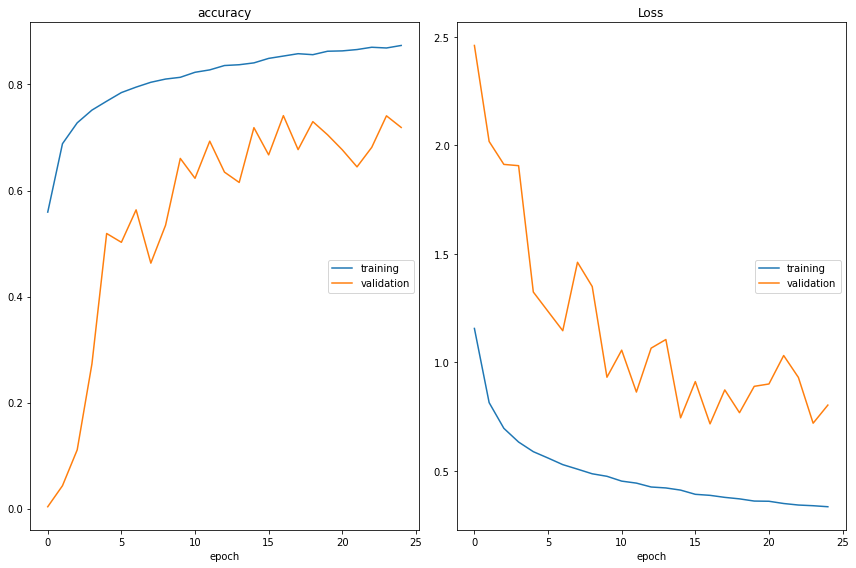

accuracy
	training         	 (min:    0.559, max:    0.874, cur:    0.874)
	validation       	 (min:    0.004, max:    0.741, cur:    0.719)
Loss
	training         	 (min:    0.335, max:    1.156, cur:    0.335)
	validation       	 (min:    0.717, max:    2.460, cur:    0.803)
795/795 [==============================] - 4s 5ms/step - loss: 0.3350 - accuracy: 0.8736 - val_loss: 0.8032 - val_accuracy: 0.7189
[[ 24   0   1   0   0   0   0]
 [  0 116   0   0   1   2   0]
 [  6  14 303   4   2  53   1]
 [  0   8   4 207   1  20   3]
 [  0   0   2   0  16   1   0]
 [  4  25  77  22  12 608  10]
 [  0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        25
           1       0.71      0.97      0.82       119
           2       0.78      0.79      0.79       383
           3       0.89      0.85      0.87       243
           4       0.50      0.84      0.63        19
           5       0.89      0.80      0.84     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: multi_liwc_aud_ver1/assets


In [ ]:
model_m = train_multichannel_liwcaud(X_train_liwc,X_train_aud,y_train_tab,X_test_liwc,X_test_aud,y_test_tab,'multi_liwc_aud_ver1',epochs=275)


In [ ]:
pip install --upgrade tabnet

In [ ]:
from tabnet import TabNet, TabNetClassifier  

In [ ]:
## feature columns

liwc_feature_cols = []
for col_name in [c for c in tabular_cols if c not in ['F0','voice_probability','pcm_loudness']]:
    liwc_feature_cols.append(tf.feature_column.numeric_column(col_name))
     
aud_feature_cols = []
for col_name in ['F0','voice_probability','pcm_loudness']:
    aud_feature_cols.append(tf.feature_column.numeric_column(col_name))
    

In [ ]:
def train_multichannel_liwcaud_tabnets(X_train_liwc,X_train_aud,y_train,X_test_liwc,X_test_aud,y_test,name,num_out=7,epochs=350):
  
  ## liwc 
  tn1 = TabNet(feature_columns=liwc_feature_cols, output_dim=32) 
  inputs_text = Input(shape=(X_train_liwc.shape[-1],))
  text_layer = tn1.layers[2](inputs_text)
  text_layer = tn1.layers[3](text_layer)

  #for layer in tn1.layers[3:5]:
  #  text_layer = layer(text_layer)
  
  flat_text = Flatten()(text_layer)
  
  ## prosodic  
  tn2 = TabNet(feature_columns=aud_feature_cols, output_dim=32)
  inputs_aud = Input(shape=(X_train_aud.shape[-1],))
  aud_layer = tn2.layers[2](inputs_aud)
  aud_layer = tn2.layers[3](aud_layer)
  #for layer2 in tn2.layers[3:5]:
  # aud_layer = layer2(aud_layer)  
  flat_aud = Flatten()(aud_layer)
  
  # normalize tabulars 
  scaler = StandardScaler()
  X_train_liwc = scaler.fit_transform(X_train_liwc)
  X_test_liwc = scaler.transform(X_test_liwc) 

  X_train_aud = scaler.fit_transform(X_train_aud)
  X_test_aud = scaler.transform(X_test_aud) 
  
  merged = concatenate([flat_text, flat_aud])

  dense1 = Dense(128, activation='relu')(merged)
  dense2 = Dense(64, activation='relu')(dense1)
  outputs = Dense(7, activation='softmax')(dense2)
  
  model = Model(inputs=[inputs_text, inputs_aud], outputs=outputs)
  for layer in model.layers[:1]:
    layer.trainable = False  
     
  model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(1e-3),
              metrics=['accuracy'])
  
  
  history = model.fit([X_train_liwc,X_train_aud], y_train, batch_size = 32, epochs=epochs,validation_split=0.1) 
   
  preds = model.predict([X_test_liwc,X_test_aud]) 
  preds = [x.argmax() for x in preds] 
  y_true = [x.argmax() for x in y_test]

  print(confusion_matrix(y_true,preds))
  print(classification_report(y_true,preds)) 
  print(accuracy_score(y_true,preds))  
    
  model.save(name)  
   
  return model     
  

In [ ]:
train_multichannel_liwcaud_tabnets(X_train_liwc,X_train_aud,y_train_tab,X_test_liwc,X_test_aud,y_test_tab,'tabnet_liwcandpros_v2',num_out=7, epochs=55)

In [ ]:
'''
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet = TabNetClassifier()

tabnet.fit(X_train=X_train_liwc, y_train=np.array([np.argmax(c) for c in y_train_tab]),
              eval_set=[(X_test_liwc, np.array([np.argmax(c) for c in y_test_tab]))], 
              patience=300, max_epochs=1500,eval_metric=['balanced_accuracy'])   
              
print(classification_report([np.argmax(c) for c in y_test_tab],tabnet.predict(X_test_liwc)))
print(confusion_matrix([np.argmax(c) for c in y_test_tab],tabnet.predict(X_test_liwc)))  
'''

              precision    recall  f1-score   support

           0       0.41      0.96      0.57        25
           1       0.37      0.98      0.53       119
           2       0.62      0.69      0.65       383
           3       0.85      0.78      0.82       243
           4       0.33      0.79      0.47        19
           5       0.86      0.53      0.66       758
           6       0.00      0.00      0.00         0

    accuracy                           0.65      1547
   macro avg       0.49      0.68      0.53      1547
weighted avg       0.75      0.65      0.67      1547

[[ 24   1   0   0   0   0   0]
 [  0 117   0   0   0   1   1]
 [  5  54 263   2   7  52   0]
 [  4  28   6 190   3  11   1]
 [  2   1   1   0  15   0   0]
 [ 24 118 156  31  20 402   7]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LSTM

In [ ]:
## make model
max_words = 64
max_seq = 64
emb_dim = 100  

model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length=X_train_tab.shape[1])) 
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


## train 
epochs = 60 
batch_size = 64   
 
history = model.fit(X_train_tab, y_train_tab, epochs=epochs, batch_size=batch_size,validation_split=0.1) 

preds = model.predict(X_test_tab)
print(classification_report([np.argmax(c) for c in y_test_tab],[np.argmax(c) for c in preds]))
print(confusion_matrix([np.argmax(c) for c in y_test_tab],[np.argmax(c) for c in preds]))  

 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 100)          6400      
                                                                 
 bidirectional (Bidirectiona  (None, 115, 256)         234496    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


WideDeep (TabMlp, TabResnet, TabNet, TabTransformer, SAINT, FTTransformer TabPerceiver, TabFastFormer)

https://github.com/jrzaurin/pytorch-widedeep 

In [ ]:
! pip install pytorch-widedeep
! pip install transformers

In [ ]:
import transformers

In [ ]:
import pytorch_widedeep

In [ ]:
import torch 

In [ ]:
from pytorch_widedeep.models import TabMlp, WideDeep, TabResnet, BasicRNN, TabNet, FTTransformer,TabFastFormer 
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import Accuracy, Recall, Precision 

In [ ]:
# DeepTabular 
tab_preprocessor = TabPreprocessor(continuous_cols=tabular_cols) 
X_tab = tab_preprocessor.fit_transform(train_data[tabular_cols]) 
 


In [ ]:
tff = TabFastFormer(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tabular_cols,
  
)
model = WideDeep(deeptabular=tff , pred_dim=7)
trainer = Trainer(model, objective="categorical_cross_entropy", metrics=[(Recall)])
trainer.fit(X_tab=X_tab, target=[np.argmax(c) for c in y_train_tab], n_epochs=50, batch_size=256, val_split=0.2)  

valid: 100%|██████████| 23/23 [00:00<00:00, 25.52it/s, loss=0.469, metrics={'rec': 0.8251}]


In [ ]:
preds = trainer.predict(X_tab = tab_preprocessor.transform(test_data[tabular_cols])) 

print(classification_report([np.argmax(c) for c in y_test_tab],preds))
print(confusion_matrix([np.argmax(c) for c in y_test_tab],preds))  

predict: 100%|██████████| 7/7 [00:00<00:00, 16.16it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.84      0.31        25
           1       0.84      0.74      0.79       119
           2       0.87      0.69      0.77       383
           3       0.88      0.77      0.82       243
           4       0.36      0.95      0.52        19
           5       0.82      0.80      0.81       758
           6       0.00      0.00      0.00         0

    accuracy                           0.77      1547
   macro avg       0.57      0.68      0.57      1547
weighted avg       0.83      0.77      0.79      1547

[[ 21   0   1   0   3   0   0]
 [  6  88   0   0   2  23   0]
 [ 30   3 265   1   4  75   5]
 [  7   0   3 187   5  35   6]
 [  0   0   1   0  18   0   0]
 [ 45  14  36  24  18 606  15]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ftt = FTTransformer(column_idx=tab_preprocessor.column_idx,  continuous_cols=tabular_cols)
model = WideDeep(deeptabular=ftt, pred_dim=7) 

trainer = Trainer(model, objective="categorical_cross_entropy", metrics=[(Recall)])
trainer.fit(X_tab=X_tab, target=[np.argmax(c) for c in y_train_tab], n_epochs=50, batch_size=256, val_split=0.2)  

valid: 100%|██████████| 23/23 [00:00<00:00, 29.83it/s, loss=0.518, metrics={'rec': 0.8411}]


In [ ]:
preds = trainer.predict(X_tab = tab_preprocessor.transform(test_data[tabular_cols])) 

print(classification_report([np.argmax(c) for c in y_test_tab],preds))
print(confusion_matrix([np.argmax(c) for c in y_test_tab],preds))   

predict: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


              precision    recall  f1-score   support

           0       0.30      0.96      0.46        25
           1       0.88      0.84      0.86       119
           2       0.90      0.71      0.80       383
           3       0.90      0.81      0.86       243
           4       0.23      0.89      0.37        19
           5       0.84      0.83      0.83       758
           6       0.00      0.00      0.00         0

    accuracy                           0.80      1547
   macro avg       0.58      0.72      0.60      1547
weighted avg       0.85      0.80      0.82      1547

[[ 24   0   0   0   1   0   0]
 [  1 100   0   0   4  14   0]
 [ 14   1 273   4  18  71   2]
 [  4   0   3 198   2  34   2]
 [  0   0   0   0  17   2   0]
 [ 36  12  27  18  31 626   8]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tabresnet = TabResnet(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tabular_cols,
    blocks_dims=[200, 100, 100],
    mlp_hidden_dims=[100, 50],
)
model = WideDeep(deeptabular=tabresnet, pred_dim=7) 

In [ ]:
trainer = Trainer(model, objective="categorical_cross_entropy", metrics=[(Recall)])
trainer.fit(X_tab=X_tab, target=[np.argmax(c) for c in y_train_tab], n_epochs=50, batch_size=256, val_split=0.2) 

valid: 100%|██████████| 23/23 [00:00<00:00, 48.80it/s, loss=0.651, metrics={'rec': 0.8381}]


In [ ]:
preds = trainer.predict(X_tab = tab_preprocessor.transform(test_data[tabular_cols])) 

print(classification_report([np.argmax(c) for c in y_test_tab],preds))
print(confusion_matrix([np.argmax(c) for c in y_test_tab],preds))  

              precision    recall  f1-score   support

           0       0.36      0.96      0.53        25
           1       0.75      0.87      0.80       119
           2       0.77      0.74      0.75       383
           3       0.89      0.80      0.84       243
           4       0.34      1.00      0.51        19
           5       0.83      0.75      0.79       758
           6       0.00      0.00      0.00         0

    accuracy                           0.77      1547
   macro avg       0.56      0.73      0.60      1547
weighted avg       0.81      0.77      0.78      1547

[[ 24   0   1   0   0   0   0]
 [  2 103   1   0   0  13   0]
 [ 16   6 282   5   6  64   4]
 [  2   0   4 194   1  38   4]
 [  0   0   0   0  19   0   0]
 [ 22  29  80  18  30 568  11]
 [  0   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
